In [1]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, reduce
from tqdm import tqdm, trange
from torch.nn import functional as F
from utils.download_mnist import multi_mnist_dataloader_test, multi_mnist_dataloader_train, mnist_dataloader_train
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 
from experiment import OptiEBM

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def make_adaptive_experiment(config):
    ebm = make_energy_model(config, path=path)
    emb = ebm.to("cuda")
    adapt = OptiEBM(config, ebm)
    return adapt

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def pixelwise_varaince(imgs):
    ex = reduce(imgs, "b h w -> h w", "mean")
    ex2 = reduce(imgs**2, "b h w -> h w", "mean")
    return ex2 - ex**2

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

In [38]:
model_name = "multi_mnist/gan/langvein/inpainting"
config = get_model_config(model_name)

In [39]:
config["exp_params"]["batch_size"] = 1
dm = multi_mnist_dataloader_test(config, path=path)

In [40]:
gen = iter(dm)
x, y = next(gen)
x = x.to("cuda")

In [57]:
x, y = next(gen)
x = x.to("cuda")

In [58]:
config["operator_params"]["size"] = 32

In [51]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def random_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    out = []
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.random_sample(imgs, 10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach())
        fig, axs= plt.subplots(1, 2)
        axs[0].imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        axs[1].imshow(rearrange(x_hat.cpu().detach().numpy(), "c h w -> (c h) w" ))
        plt.show()
    return out

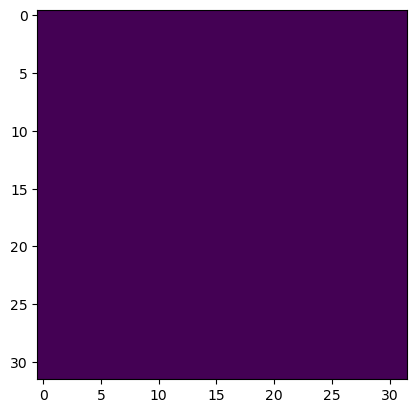

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


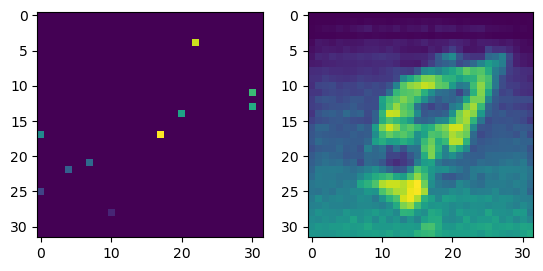

100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


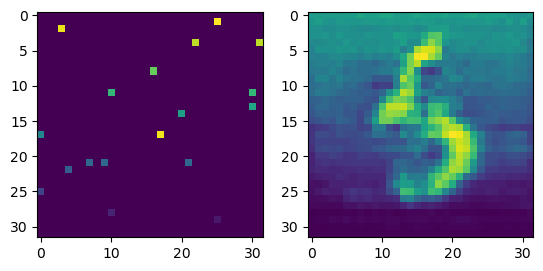

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


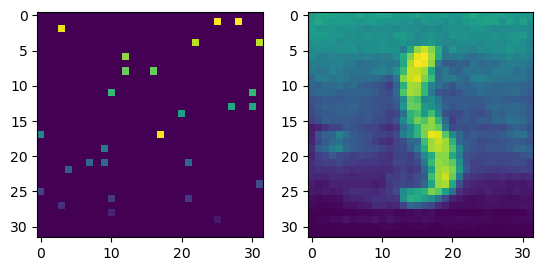

100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


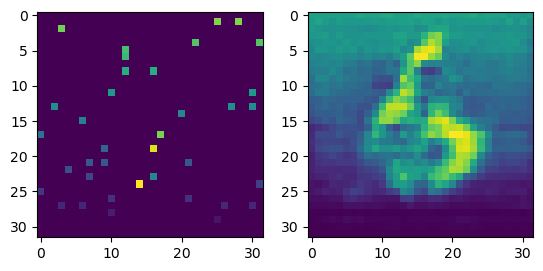

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


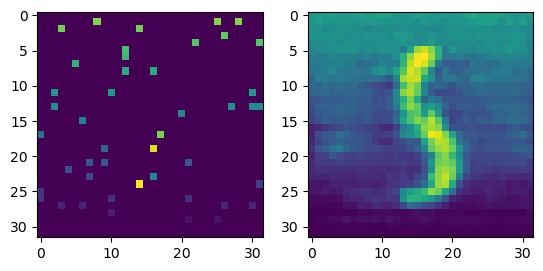

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


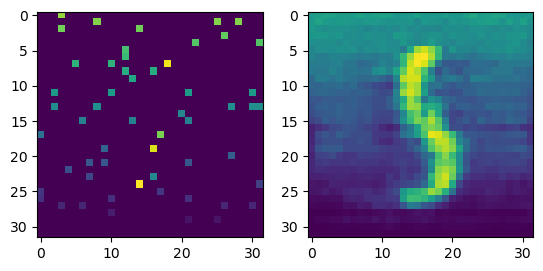

100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


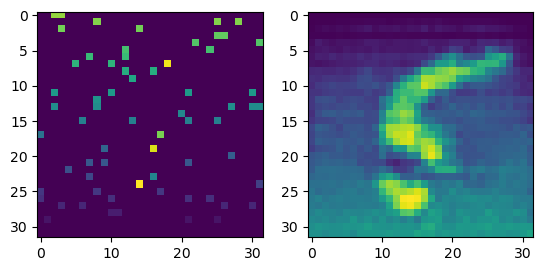

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


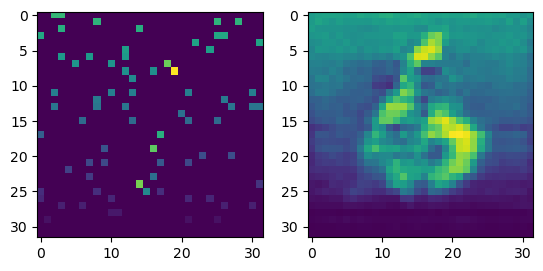

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


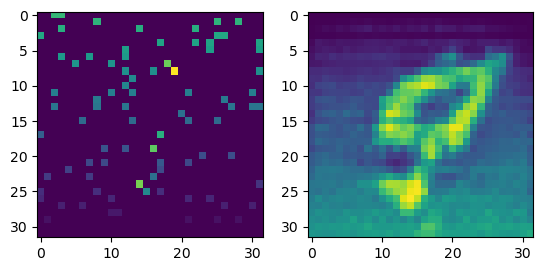

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


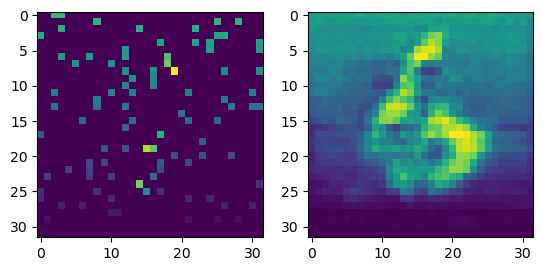

100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


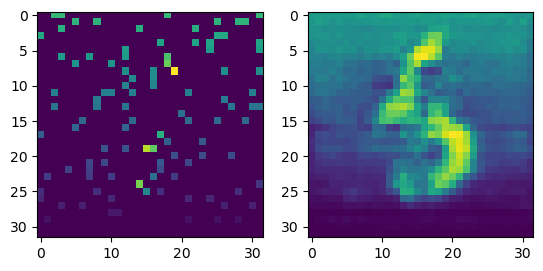

100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


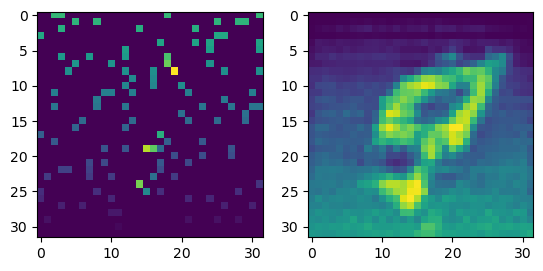

100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


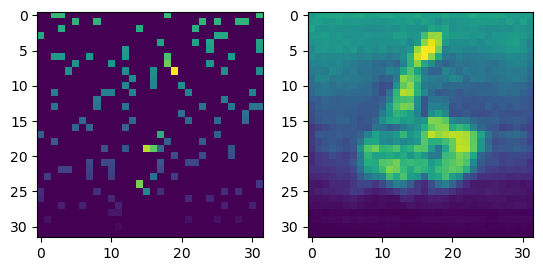

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


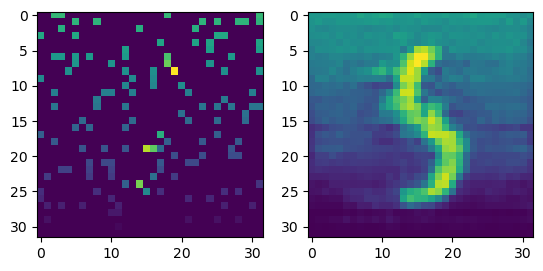

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


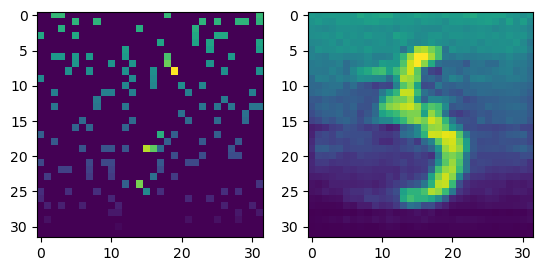

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


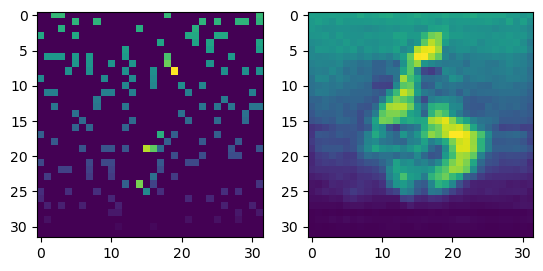

100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


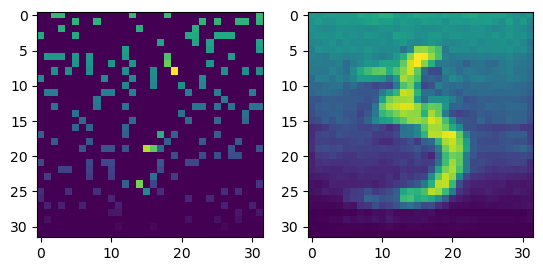

100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


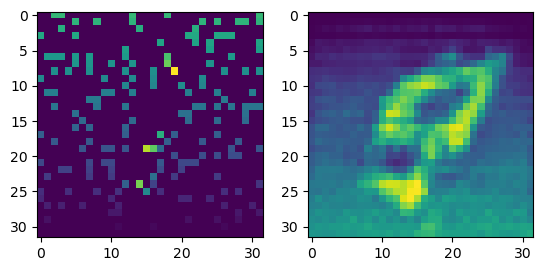

100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


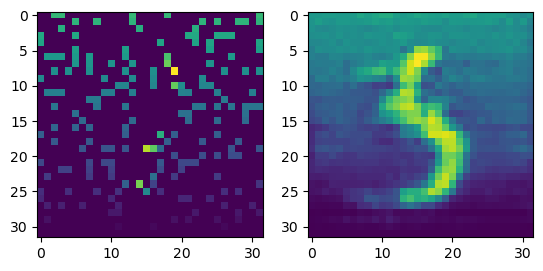

100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


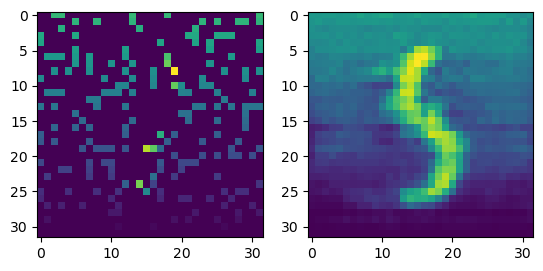

In [52]:
out1 = random_iteration(x)

In [59]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def thomospon_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    out = []
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.thomospon_sample(imgs, 10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach())
        fig, axs= plt.subplots(1, 2)
        axs[0].imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        axs[1].imshow(rearrange(x_hat.cpu().detach().numpy(), "c h w -> (c h) w" ))
        plt.show()
    return out

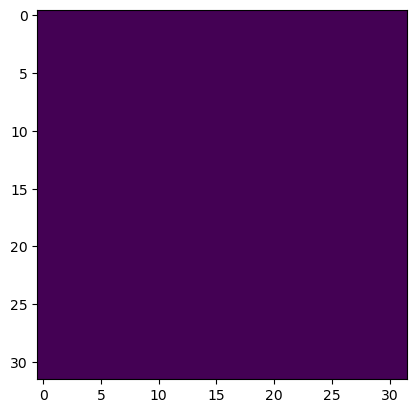

100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


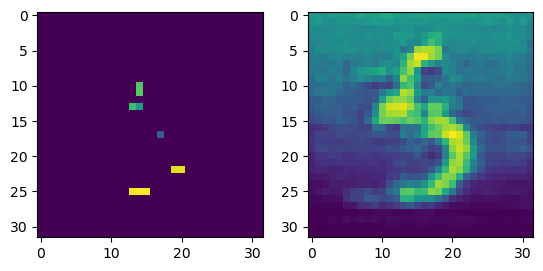

100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


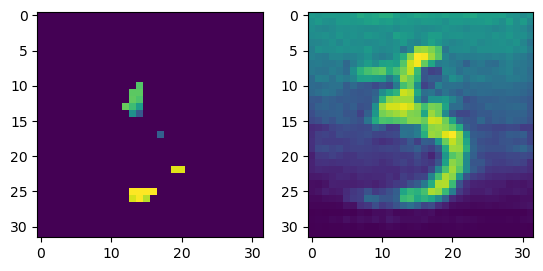

100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


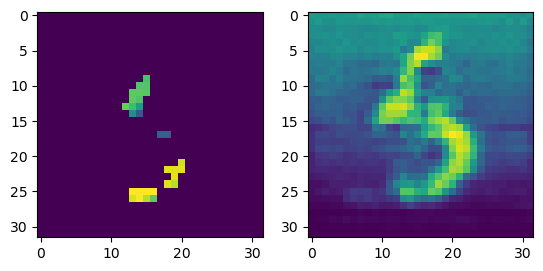

100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


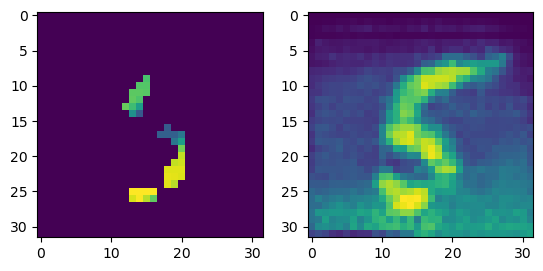

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


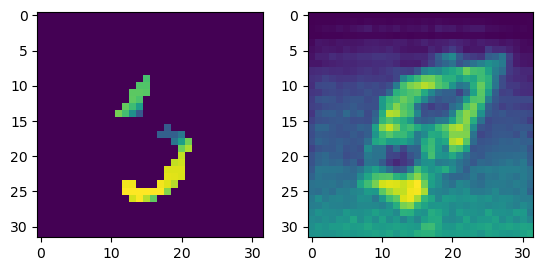

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


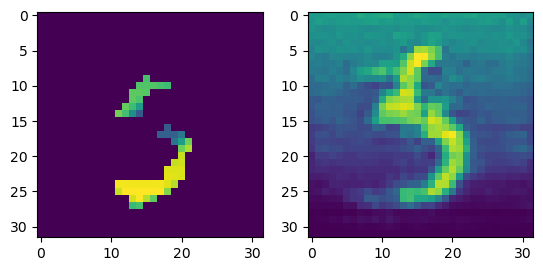

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


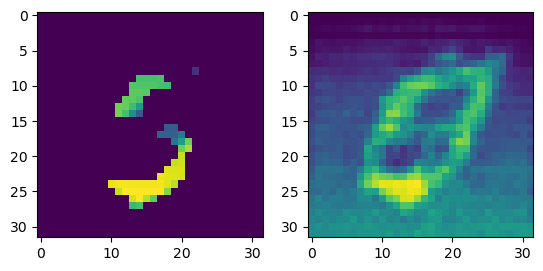

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


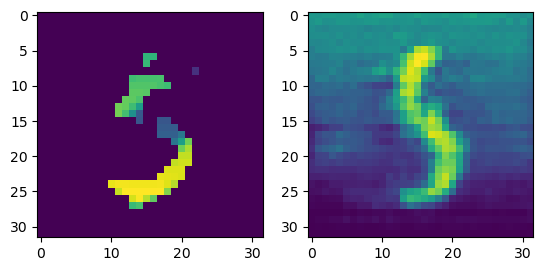

100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


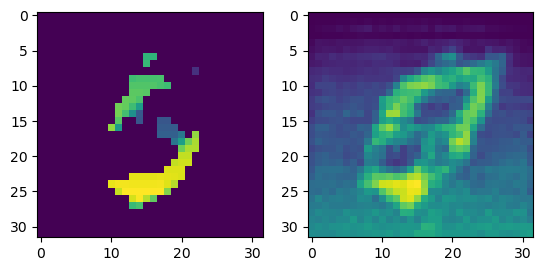

100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


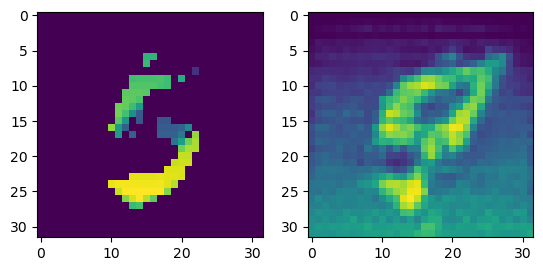

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


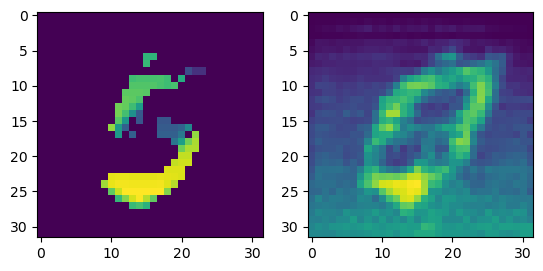

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


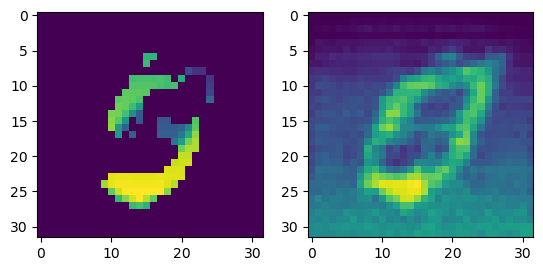

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


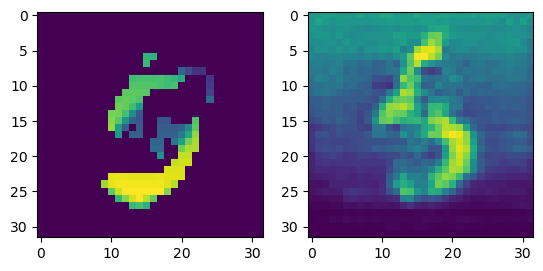

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


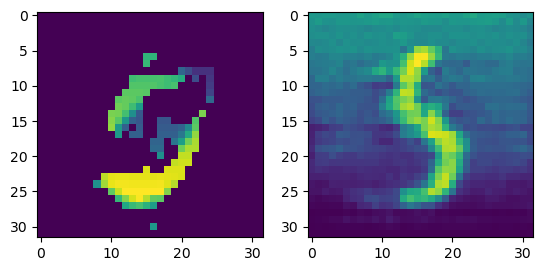

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


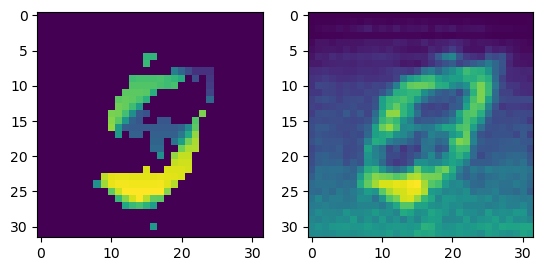

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


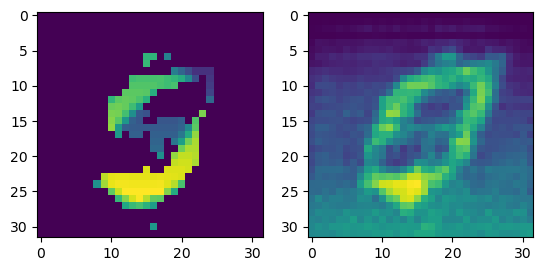

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


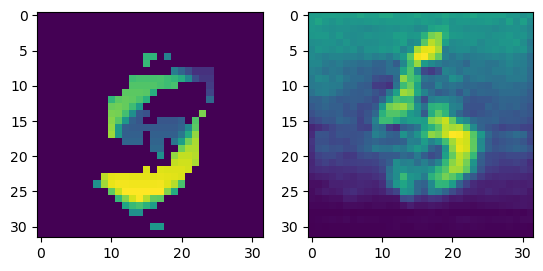

100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


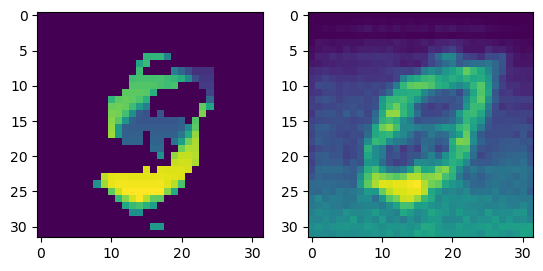

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


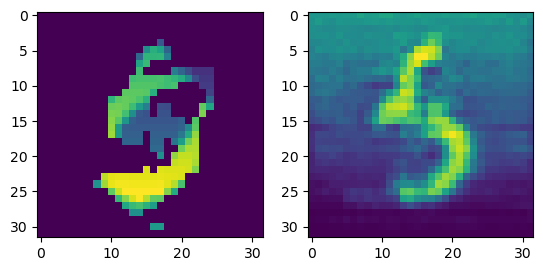

100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


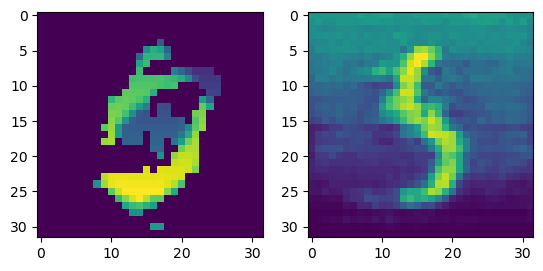

In [60]:
out2 = thomospon_iteration(x)

In [61]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def ucb_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    out= []
    n_samples = 10
    max_ = 0
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.ucb_sample(imgs, k=50, num_pixels_per_samples=10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach())
        fig, axs= plt.subplots(1, 2)
        axs[0].imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        axs[1].imshow(rearrange(x_hat.cpu().detach().numpy(), "c h w -> (c h) w" ))
        plt.show()
    return out

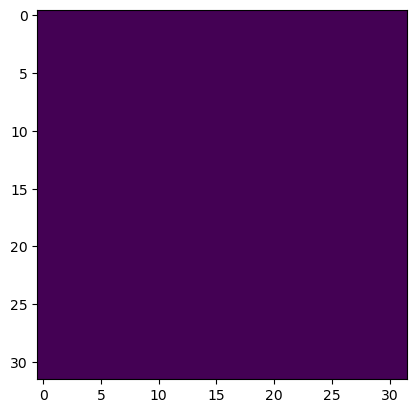

100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


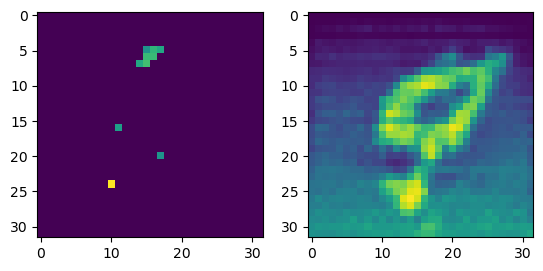

100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


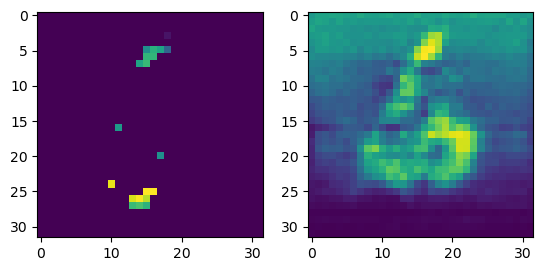

100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


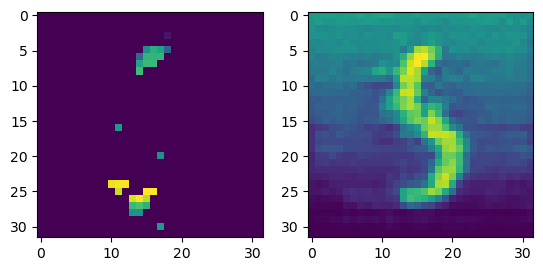

100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


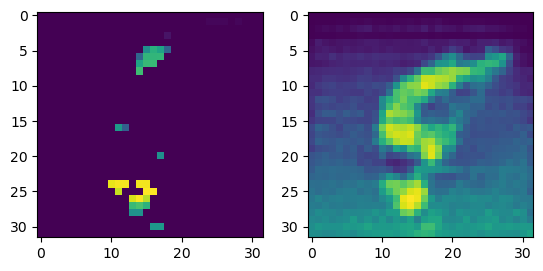

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


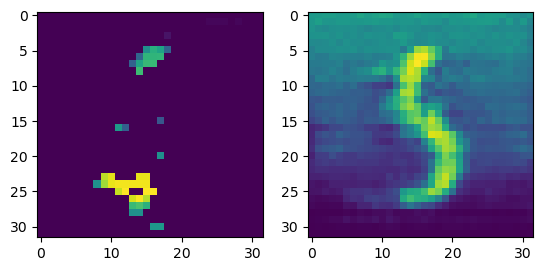

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


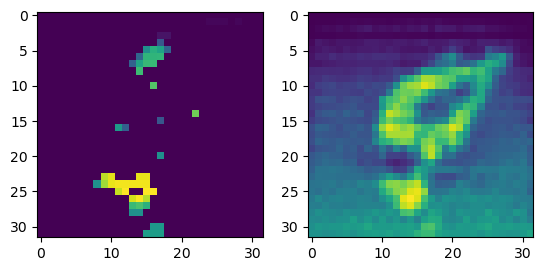

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


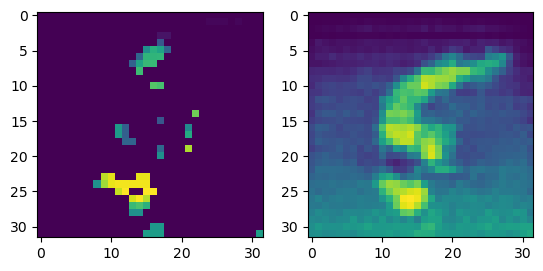

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


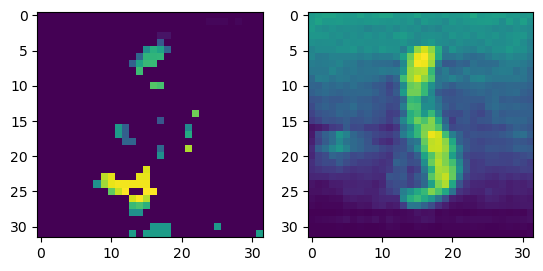

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


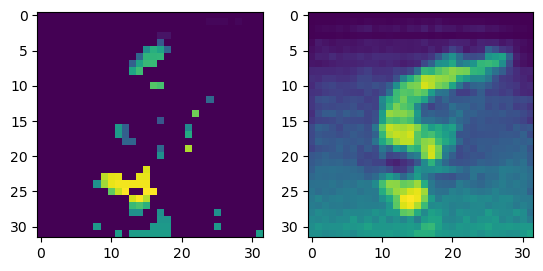

100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


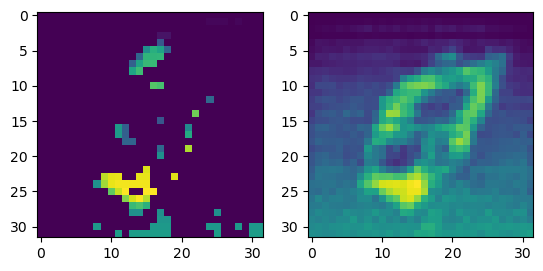

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


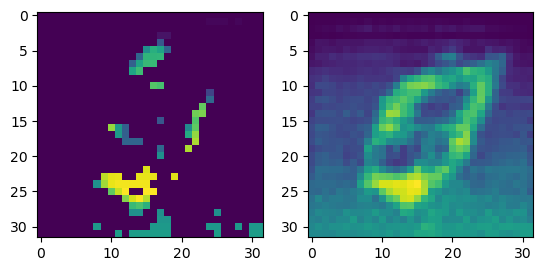

100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


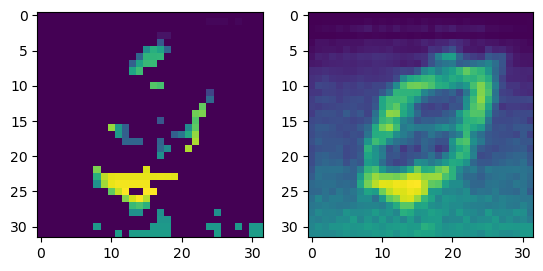

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


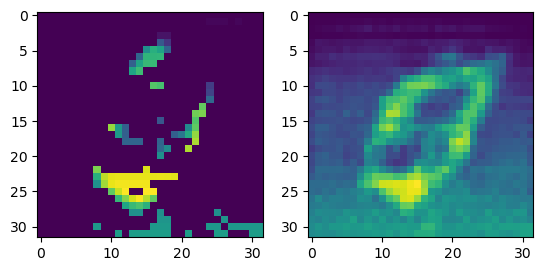

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


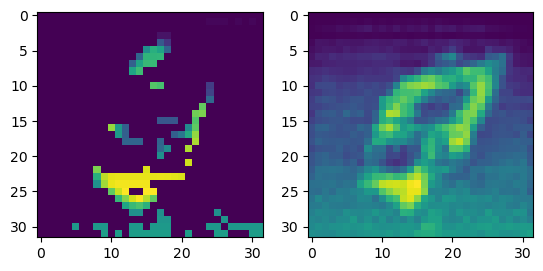

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


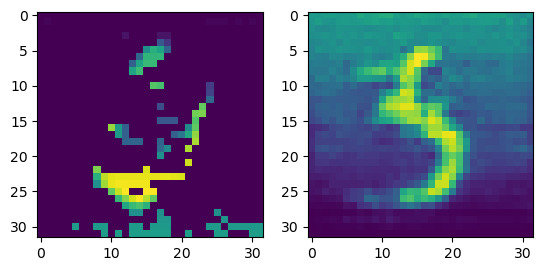

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


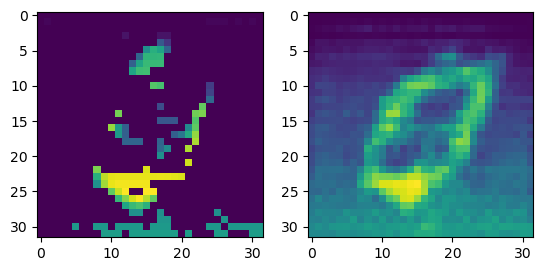

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


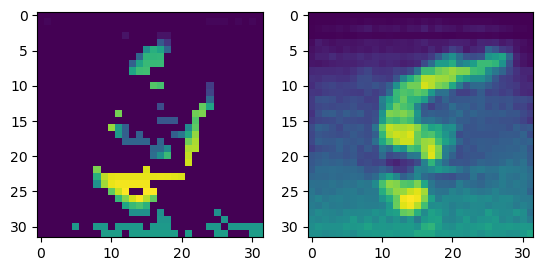

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


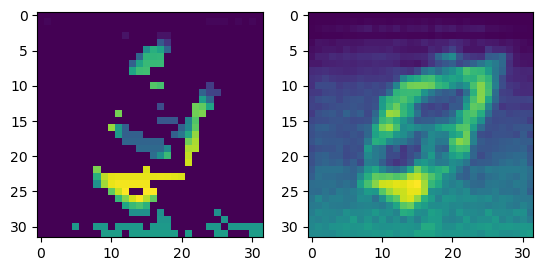

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


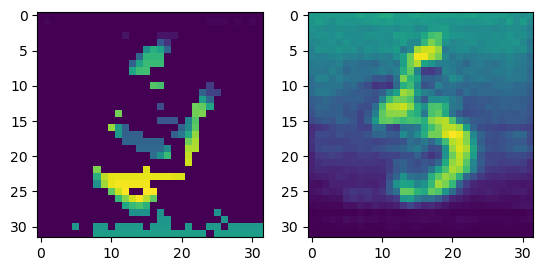

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


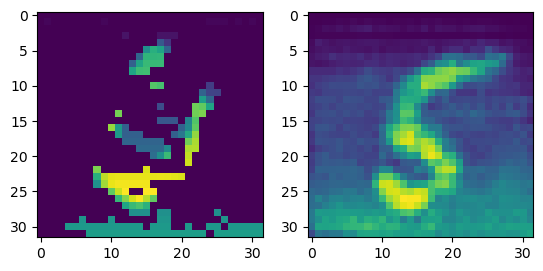

In [62]:
out3= ucb_iteration(x)

In [11]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image
def ucb_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    out= []
    n_samples = 10
    max_ = 0
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.ucb_sample(imgs, k=50, num_pixels_per_samples=10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach())
    return out

def random_pick_iteration(img):
    dm = multi_mnist_dataloader_train(config, path=path, shuffle=True)
    config["exp_params"]["batch_size"] = 1
    gen = iter(dm)
    x, y = next(gen)
    x = x.to("cuda")
    adapt = make_adaptive_experiment(config)
    ri, A = adapt.random_pick_sample(x, 10)
    adapt.update_operator(A)
    x_tilde = adapt.ebm.operator(img)
    return torch.max(x_tilde).cpu().detach().numpy()

def thomospon_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    out = []
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.thomospon_sample(imgs, 10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach())
    return out

100%|██████████| 10/10 [00:00<00:00, 31.68it/s]


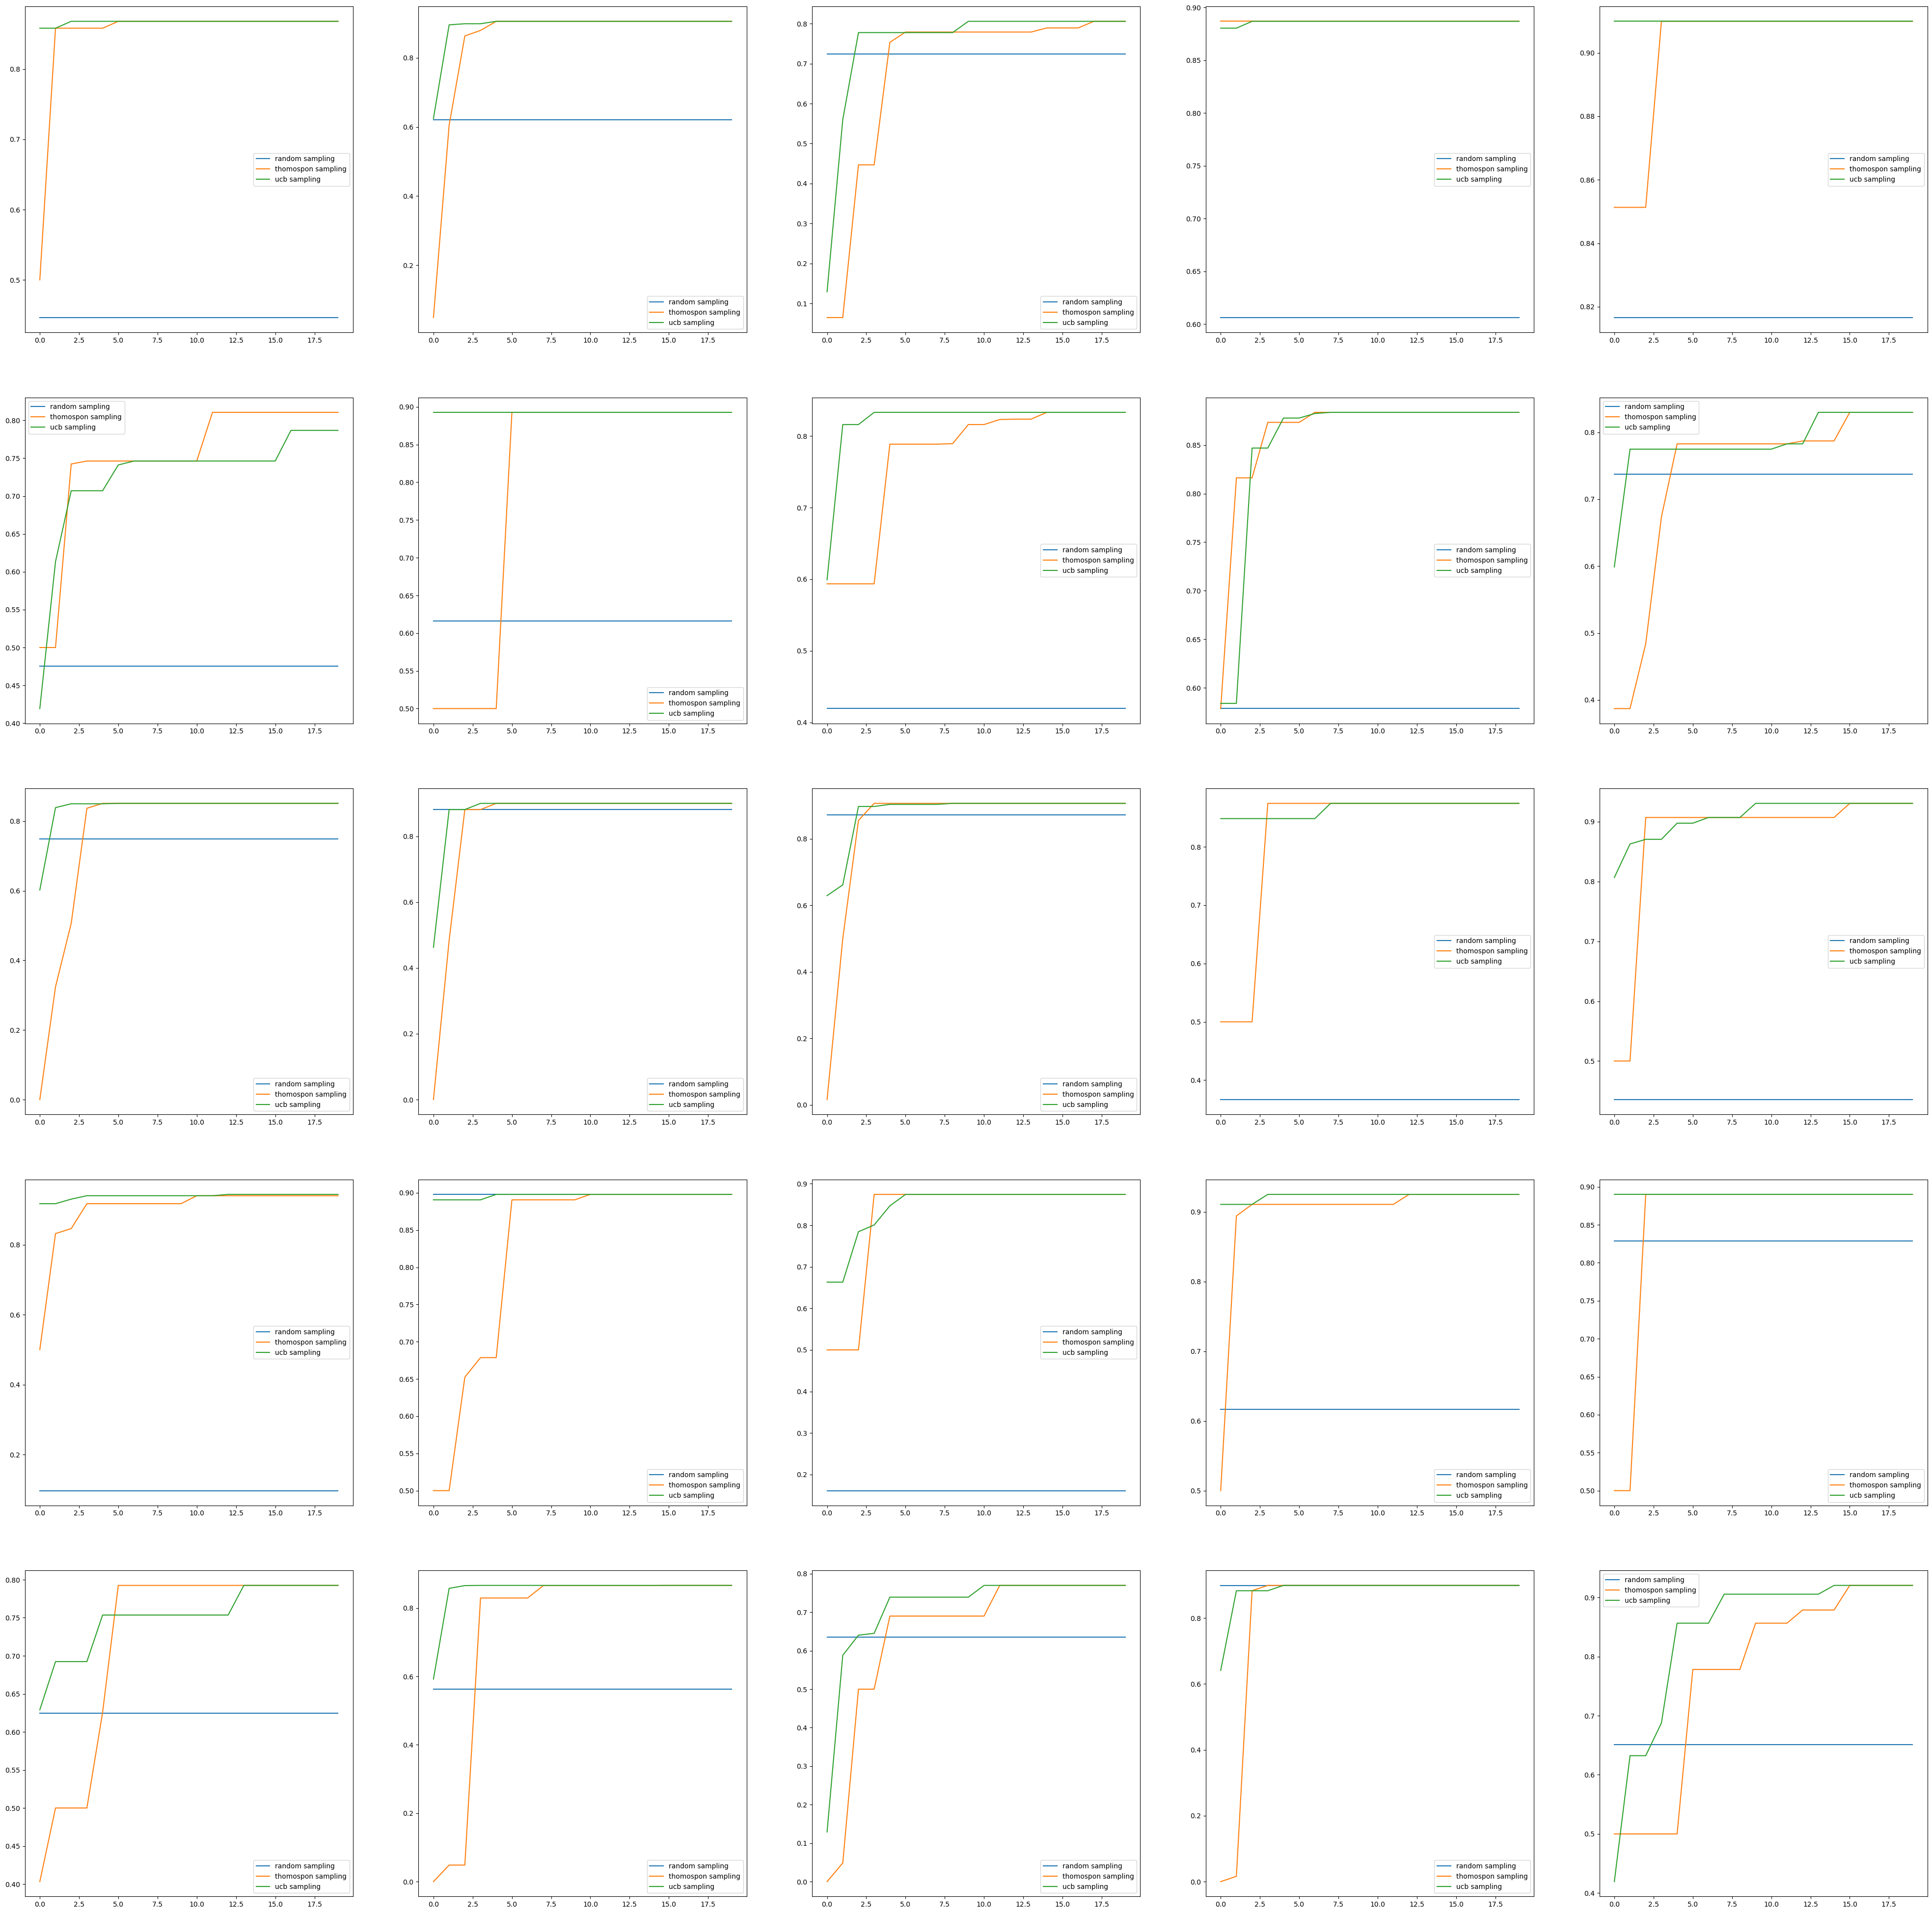

In [19]:
fig, axs = plt.subplots(5, 5, figsize=(50, 50))
for l in range(5):
    for t in range(5):
        x, y = next(gen)
        x = x.to("cuda")
        ucb=  ucb_iteration(x)
        thomospon = thomospon_iteration(x)
        random = random_pick_iteration(x)
        axs[l, t].plot([random]*len(ucb))
        axs[l, t].plot(ucb)
        axs[l, t].plot(thomospon)
        axs[l, t].legend(['random sampling','thomospon sampling', 'ucb sampling'])
plt.show()